In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

ix_cols = ['esports_match_id', 'map_name', 'team_name', 'hero_name', 'stat_name']
dedup_cols = ix_cols + ['player_name']

In [2]:
import urllib
from zipfile import ZipFile

raw_url = 'https://assets.blz-contentstack.com/v3/assets/blt321317473c90505c/blt7e0ffce2b617f0d2/5ecd3a75a84f2107d1775f56/phs_2020.zip'
map_url = 'https://assets.blz-contentstack.com/v3/assets/blt321317473c90505c/blt67ebb7496ecd1ac4/5ecd3a5d80e1cd5cdc708bb6/match_map_stats.zip'
urllib.request.urlretrieve(raw_url, './phs_2020.zip')
urllib.request.urlretrieve(map_url, './match_map_stats.zip')

with ZipFile('./phs_2020.zip', 'r') as zipObj:
   zipObj.extractall()

with ZipFile('./match_map_stats.zip', 'r') as zipObj:
   zipObj.extractall()

In [3]:
# load raw statistical data
raw_df = pd.read_csv('./phs_2020_1.csv')

# get rid of duplicates
raw_df = raw_df.drop_duplicates()
raw_df_mi = raw_df.set_index(dedup_cols)
raw_df = raw_df[~raw_df_mi.index.duplicated(keep='first')]

In [4]:
# load data about map results
map_df = pd.read_csv('./match_map_stats.csv')

# Figure out who won each map of each match
def is_win(x):
    r = x.iloc[0]
    m = map_df[(map_df.match_id == r.esports_match_id) 
               & (map_df.map_name == r.map_name)]
    return r.team_name == m.iloc[0]['map_winner']

# win or loss for each match/map/team
outcomes = raw_df.groupby(['esports_match_id', 'map_name', 'team_name']).apply(is_win)

In [5]:
# separate out stats into counting stats (e.g. damage) and ratio stats (e.g. accuracy)
avg_stats = set()
stopwords = [' per ', 'efficiency', 'accuracy', 'percentage', 'percent of', ' rate', 'average']
for s in set(raw_df['stat_name']):
    for sw in stopwords:
        if sw in s.lower():
            avg_stats.add(s)

# we only care about cumulative stats right now, we'll do our own normalizing
cum_stats = set(raw_df['stat_name']) - avg_stats

# Filter out average stats from the raw data
gb = raw_df[raw_df.stat_name.isin(cum_stats)].groupby(ix_cols).sum()
stats = gb['stat_amount'].unstack()
wide_stats = stats.unstack().dropna(axis=1, how='all')
wide_stats.columns = wide_stats.columns.swaplevel()
wide_stats = wide_stats.sort_index(axis=1)

In [6]:
# Break out stats by player/map

gb = raw_df[raw_df.stat_name.isin(cum_stats)].groupby(['player_name'] + ix_cols).sum()
stats = gb['stat_amount'].unstack()

player_stats = stats.unstack().dropna(axis=1, how='all')
player_stats.columns = player_stats.columns.swaplevel()
player_stats = player_stats.sort_index(axis=1)

In [7]:
# create separate dataframes for average stats
gb = raw_df[raw_df.stat_name.isin(avg_stats | {'Time Played'})].groupby(['player_name'] + ix_cols).sum()

stats = gb['stat_amount'].unstack()
player_avg_stats = stats.unstack().dropna(axis=1, how='all')

# now combine average stats per hero/map
gb_ix = ['esports_match_id', 'map_name', 'team_name', 'hero_name']

# weight averages by time played
def weighted_sum(x):
    weighted_df = x.drop('Time Played', axis=1).multiply(x['Time Played'], axis=0)
    return weighted_df.sum() / x['Time Played'].sum()

avg_stat_df = stats.groupby(gb_ix).apply(weighted_sum)

# add time played back in as a stat
avg_stat_df['Time Played'] = stats[['Time Played']].groupby(gb_ix).sum()

# move hero name from the index to the column name
avg_stat_df = avg_stat_df.unstack().dropna(axis=1, how='all')

# put heroes as top column index and sort alphabetically
avg_stat_df.columns = avg_stat_df.columns.swaplevel()
avg_stat_df = avg_stat_df.sort_index(axis=1)

# drop columns with only zeros
avg_stat_df = avg_stat_df.loc[:, (avg_stat_df.fillna(0) != 0).any(axis=0)]

In [8]:
# Remove seldom-used heroes from the dataset

heroes = set(wide_stats.columns.get_level_values(0))
heroes.remove('All Heroes')
for h in list(heroes):
    if wide_stats[h]['Time Played'].sum() / 3600 < 3:
        print('removing', h)
        heroes.remove(h)

removing Bastion
removing Roadhog
removing Junkrat


In [9]:
## Generate stats by group of heroes. Break out stats by DPS, tank, and support.

from functools import reduce
groups = {
    'All Tanks': {'Sigma', 'Zarya', 'Reinhardt', 'Winston', 'Orisa', 'Wrecking Ball', 'D.Va'},
    'All DPS': {'Reaper', 'Echo', 'Widowmaker', 'Pharah', 'Tracer', 'Doomfist', 'McCree', 
                'Torbjörn', 'Sombra', 'Hanzo', 'Ashe', 'Symmetra', 'Mei', 'Genji', 'Soldier: 76'},
    'All Supports': {'Ana', 'Zenyatta', 'Lúcio', 'Brigitte', 'Mercy', 'Moira', 'Baptiste'},
}

def create_group(data, group, name):
    common_stats = reduce(lambda a, b: a & b, (data[h].columns for h in group))
    out = pd.DataFrame(index=data.index)
    data_z = data.fillna(0)
    for s in common_stats:
        out[name, s] = sum(data_z[h][s] for h in group)
    return out

for name, group in groups.items():
    # drop stats if they're already there and recalculate
    if name in wide_stats:
        wide_stats = wide_stats.drop(name, axis=1)
    wide_stats = pd.concat([wide_stats, create_group(wide_stats, group, name)], axis=1)
    
    if name in player_stats:
        player_stats = player_stats.drop(name, axis=1)
    player_stats = pd.concat([player_stats, create_group(player_stats, group, name)], axis=1)
    
print(wide_stats.shape, player_stats.shape)

(1026, 1462) (6156, 1462)


In [123]:
from scipy.stats import pointbiserialr, zscore
import numpy as np

# Get point-biserial correlation between one stat and wins
def get_corr(col, filt=None):
    if type(col) != pd.Series:
        col = pd.Series(col)
    
    if filt is None:
        filt = ~col.isnull()
        
    filt = filt & ~col.isnull()
    
    if sum(filt) < 3:
        return None

    X = zscore(col[filt])
    y = outcomes[filt]
    return pointbiserialr(y, X)

# Print correlations for each column in a dataframe
def print_corrs(data):
    corrs = []
    for stat in data.columns:
        res = get_corr(data[stat])
        if res is None:
            continue
            
        r, p = res
        if np.log10(p) < -1.5:
            corrs.append((r, stat))

    res = sorted(corrs, key=lambda i: -abs(i[0]))
    for r in res:
        print('%s: %.3f' % (r[1], r[0]))
        
# Change stats from cumulative to per-10-minutes
def get_hs_per_10(hero_stats):
    return hero_stats.apply(
        lambda x: x.drop('Time Played') 
                  / (x['Time Played'] / 600),
        axis=1)
        
    
# Change stats from cumulative to per-10-minutes
def get_stats_per_10(stats):
    df = pd.DataFrame(index=stats.index, columns=stats.columns)
    heroes = set(stats.columns.get_level_values(0))
    for h in heroes:
        df[h] = get_hs_per_10(stats[h])
        
    return df
    
# Print all stats for a hero, and how much each stat correlates with winning
def print_hero_stats(hero):
    hero_stats = wide_stats[hero]
    hs_per_10 = get_hs_per_10(hero_stats)
    print(hero, hero_stats['Time Played'].sum() / 3600)
    print_corrs(hero_stats)
    
stats_per_10 = get_stats_per_10(wide_stats)

In [12]:
def get_var_ratio_vs_wins(attr1, attr2=False, heroes=heroes):
    # average per 10 minutes for a team
    as_per_10 = get_hs_per_10(wide_stats['All Heroes'])

    for h in heroes:
        # average stats per 10 minutes for each hero
        hs = get_hs_per_10(wide_stats[h])

        if attr1 not in hs.columns:
            continue

        # compute average kill participation for the hero (fraction of total 
        # kills that the hero took part in) and correlate with win percentage
        if attr2:
            if attr2 not in hs.columns:
                continue
            res = get_corr(hs[attr1] / hs[attr2])
        # if attr2 is not provided, compute a ratio against the team total
        else:
            res = get_corr(hs[attr1] / as_per_10[attr1])
        
        if res is None:
            # print('** Not enough data for', h, '**')
            continue

        r, p = res
        tp = wide_stats[h]['Time Played'].sum() / 3600
        ci = np.log10(p)

        # only print significant results
        if len(heroes) < 5 or p < 0.05:
            print('%s (%.0f hours): %.3f, p=%.3f' % (h, tp, r, p))
            

get_var_ratio_vs_wins(attr1='Final Blows',
                      attr2='Eliminations',
                      heroes=['All Supports', 'All DPS', 'All Tanks', 'All Heroes'])

All Supports (410 hours): 0.029, p=0.361
All DPS (409 hours): -0.127, p=0.000
All Tanks (408 hours): -0.053, p=0.089
All Heroes (1229 hours): -0.145, p=0.000


In [13]:
# Compute the number of ultimates negated by a D.Va as a fraction of the negatable ults they faced in a round
# (only count mei, zarya, and tracer, though hanzo is technically possible)

def get_ult_negation_pct(stats):
    wsz = stats.fillna(0)
    series = []

    for i in range(len(wsz.index)):
        j = i + 1 if i % 2 == 0 else i - 1
        ri = wsz.iloc[i]
        rj = wsz.iloc[j]
        ults_against = sum(rj[h]['Ultimates Used'] for h in ['Mei', 'Zarya', 'Tracer'])

        val = np.nan
        if ults_against > 0 and ri['D.Va']['Time Played']:
            val = ri['D.Va']['Ultimates Negated'] / ults_against
            #print(ri['D.Va']['Ultimates Negated'], ults_against, outcomes.iloc[i])

        elif ri['D.Va']['Ultimates Negated']:
            print(wsz.index[i],wsz.index[j], ri['D.Va']['Ultimates Negated'])

        series.append(val)

    return pd.Series(series, index=stats.index)

print(get_corr(get_ult_negation_pct(wide_stats)))

(34495, 'Nepal', 'Toronto Defiant') (34495, 'Nepal', 'Vancouver Titans') 1.0
PointbiserialrResult(correlation=0.1348349465285932, pvalue=0.0016213642503391335)


In [16]:
# common_stats = set(stats_per_10['All Heroes'].columns) & reduce(lambda i, j: i & j, (set(stats_per_10[h].columns) for h in heroes))

predictive_stats = {
    'Hero Damage Done', 
    'Barrier Damage Done', 
    'Damage - Quick Melee',
    'Eliminations',
    'Final Blows', 
    'Melee Final Blows', 
    'Knockback Kills', 
    'Environmental Kills',
    'Solo Kills', 
    'Objective Kills',
    'Multikills', 
    'Assists', 
    'Recon Assists',
    'Offensive Assists', 
    'Defensive Assists',
    'Healing Done',  
    'Damage Taken',
    'Damage Blocked', 
    'Time Alive', 
    'Deaths', 
    'Environmental Deaths',
    'Objective Time', 
    'Time Building Ultimate',
    'Time Holding Ultimate', 
    'Ultimates Used', 
}

quick_stats = {
    'Hero Damage Done', 
    'Eliminations',
    'Final Blows', 
    'Solo Kills', 
    'Objective Kills',
    'Assists', 
    'Healing Done',  
    'Damage Taken',
    'Damage Blocked', 
    'Deaths',
    'Objective Time',
    'Time Building Ultimate',
    'Time Holding Ultimate', 
}

In [17]:
def get_ratio_stat(data, s1, s2, default=None):
    ratio = (data[s1].fillna(0) / data[s2])
    if default:
        return ratio.fillna(default)
    return ratio

stat_dict = {
    'Accuracy': ('Shots Hit', 'Shots Fired'),
    'Critical Accuracy': ('Critical Hits', 'Shots Fired'),
    'K/D': ('Eliminations', 'Deaths'),
    'Final Blows per Death': ('Final Blows', 'Deaths'),
}

In [180]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.special import expit

def filter_and_normalize(hero_stats, ah_stats, pred_stats, filter_fraction=0.3):
    if pred_stats is not None:
        pred_stats = set(pred_stats) | {'Time Played'}
        ah_stats = ah_stats[pred_stats]
        
    common_stats = set(pred_stats) & set(hero_stats.columns)
    
    # filter out maps where the hero didn't play at least a fraction of the map
    filt = (hero_stats['Time Played'].fillna(0) > (ah_stats['Time Played'] / 6) * filter_fraction)
    if sum(filt) < 3:
        print('Not enough data for', stat)
        return
    
    hero_stats = hero_stats[filt].fillna(0)
    ah_stats = ah_stats[filt].fillna(0)
    ah_stats = ah_stats.subtract(hero_stats[common_stats], fill_value=0)

    # convert stats to per-10-minutes
    ah_per_10 = get_hs_per_10(ah_stats)
    hero_per_10 = get_hs_per_10(hero_stats)
    
    # add in the portion of time this hero was played as a variable
    ah_per_10['Time Played'] = hero_stats['Time Played'] * 6 / ah_stats['Time Played']
    return ah_per_10, hero_per_10, filt
                                                                                    

# df: full statistics data
# hero: the hero to predict for
# stat: the name of the statistic to predict
def get_stat_predictor(stats, hero, stat, pred_stats=predictive_stats):
    # filter out games where this hero wasn't played much and remove its stats from totals
    ah_per_10, hero_per_10, filt = filter_and_normalize(stats[hero], stats['All Heroes'], pred_stats)
    
    if stat in stat_dict:
        hero_per_10[stat] = get_ratio_stat(stats[hero][filt], *stat_dict[stat])
        hero_per_10.fillna(hero_per_10[stat_dict[stat][0]])
        
    # try to predict this stat using the rest of the team's performance
    X = ah_per_10
    y = hero_per_10[stat]
    reg = LinearRegression().fit(X, y)
    return reg, X, y, filt


stat_pred_cache = {}

# instead of recalculating, pull the cached value when available
def get_stat_predictor_cache(data, hero, stat, pred_stats=predictive_stats):
    if (hero, stat) in stat_pred_cache:
        return stat_pred_cache[(hero, stat)]
    
    res = get_stat_predictor(data, hero, stat, pred_stats=pred_stats)
    stat_pred_cache[(hero, stat)] = res
    return res

# hero = 'Reinhardt'
# for stat in wide_stats[hero].columns:
#     if stat == 'Time Played':
#         continue
#     stat_reg, X, y, filt = get_stat_predictor(wide_stats, hero, stat)
#     print()
#     print(stat)
#     print(stat_reg.score(X, y))
#     print(pointbiserialr(outcomes[filt], y - stat_reg.predict(X)))

   
#     res = []
#     for i in range(len(X)):
#         pred = stat_reg.predict([X.iloc[i]])[0]
#         res.append((pred - y[i], X[stat].iloc[i], pred, y[i], X.index[i]))

#     res = list(sorted(res))#[::-1]
#     for i in range(10):
#         print(res[i])

In [19]:
def get_stat_win_predictor(X, y, filter_nan=False):
    if filter_nan:
        filt = ~np.isnan(X)
        X = X[filt]
        y = y[filt]
        
    else:
        filt = np.array([True] * len(y))
    
    # now use it to predict the chance of winning
    logreg = LogisticRegression(random_state=0).fit(X, y)
    
    # plot the points
    plt.figure(1, figsize=(4, 3))
    plt.clf()
    plt.scatter(X.ravel(), y, color='black', zorder=20)

    # plot some histograms
#     n_bins = 10
#     bin_width = (X.max() - X.min()) / n_bins
#     bins, edges = np.histogram(X, bins=n_bins, range=(X.min(), X.max()))
#     win_bins, _ = np.histogram(X[y], bins=n_bins, range=(X.min(), X.max()))
#     loss_bins, _ = np.histogram(X[~y], bins=n_bins, range=(X.min(), X.max()))
#     win_bar = [win_bins[i] / bins[i] for i in range(n_bins)]
#     loss_bar = [loss_bins[i] / bins[i] for i in range(n_bins)]
    
#     locs = [(edges[i] + edges[i+1]) / 2 for i in range(n_bins)]
    
#     plt.bar(locs, loss_bar, width=bin_width, color='gray')
#     plt.bar(locs, win_bar, bottom=loss_bar, width=bin_width, color='green')

    # plot the loss function
    X_test = np.linspace(X.min(), X.max(), 300)
    loss = expit(X_test * logreg.coef_ + logreg.intercept_).ravel()
    plt.plot(X_test, loss, color='red', linewidth=3)
    plt.show()
    
    return logreg, X, y, filt


def get_stat_independence(hero, stats):
    # stats must be raw, not per-10
    predictors = {}
    for stat in stats[hero].columns:
        if stat == 'Time Played':
            continue
        
        res = get_stat_predictor(stats, hero, stat)
        if res is None:
            continue
            
        stat_reg, X, y, filt = res
        stat_score = stat_reg.score(X, y)
        predictors[stat] = stat_reg
        
        print('%s: %.3f predicted by team' % (stat, stat_score))
        
        # figure out how much the stat predicts team wins
        r, p = get_corr(y, filt)
        
        if p < 0.05:
            print('Predictive power: %.3f, p=%.3f' % (r, p))
        else:
            print('Stat does not correlate with wins')
        
    return predictors

#get_stat_independence('Lúcio', stats)
predictors = get_stat_independence('D.Va', wide_stats)

All Damage Done: 0.395 predicted by team
Predictive power: 0.154, p=0.000
Assists: 0.635 predicted by team
Predictive power: 0.499, p=0.000
Barrier Damage Done: 0.384 predicted by team
Stat does not correlate with wins
Critical Hit Kills: 0.114 predicted by team
Predictive power: 0.116, p=0.003
Critical Hits: 0.301 predicted by team
Predictive power: 0.163, p=0.000
Damage - Boosters: 0.183 predicted by team
Predictive power: 0.171, p=0.000
Damage - Call Mech: 0.032 predicted by team
Stat does not correlate with wins
Damage - Micro Missiles: 0.322 predicted by team
Predictive power: 0.163, p=0.000
Damage - Pistol: 0.165 predicted by team
Predictive power: -0.201, p=0.000
Damage - Quick Melee: 0.118 predicted by team
Predictive power: 0.145, p=0.000
Damage - Self Destruct: 0.097 predicted by team
Predictive power: 0.153, p=0.000
Damage - Weapon: 0.474 predicted by team
Predictive power: 0.238, p=0.000
Damage Blocked: 0.320 predicted by team
Stat does not correlate with wins
Damage Taken:

In [20]:
def get_logreg_hero(hero, stats):
    filt = stats[hero, 'Time Alive'] > 0
    
    columns = []
    for c in stats[hero].columns:
        cor = get_corr(stats[hero, c])
        if cor is None:
            continue
        r, p = cor
        if p < 0.05 and r > 0.1:
            columns.append(c)
            
    print(columns)
    X = stats[hero][columns].loc[filt].fillna(0)
    y = outcomes[filt]
    logreg = LogisticRegression(random_state=0).fit(X, y)
    print(logreg.score(X, y))

#get_logreg_hero('D.Va', stats)

In [309]:
def create_annotate(fig, ax, scatters, labels):
    annot = ax.annotate("", xy=(0, 0), xytext=(20, 20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(sci, pi):
        pos = scatters[sci].get_offsets()[pi]
        annot.xy = pos
        annot.set_text(labels[sci][pi])

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            for sci, sc in enumerate(scatters):
                cont, ind = sc.contains(event)
                if cont:
                    update_annot(sci, ind['ind'][0])
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                    break
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    return fig.canvas.mpl_connect("motion_notify_event", hover)

In [224]:
import matplotlib.colors

def get_average(data, stat):
    stat_cols = stat_dict.get(stat)
    
    # this is a regular counting stat
    if stat_cols is None:
        return data[stat].sum() * 600 / data['Time Played'].sum()
    
    # this is a ratio stat
    s1, s2 = stat_cols
    return data[s1].sum() / data[s2].sum()


def get_player_stat(player, hero, stat, plot=False):
    # get raw data for maps where the player played the hero
    player_hero_df = player_stats.loc[player][hero]
    player_hero_df = player_hero_df[~player_hero_df['Time Played'].isnull()]
    
    # find average stats for the player and the league on this hero
    player_avg = get_average(player_hero_df, stat)
    league_avg = get_average(wide_stats[hero], stat)
    print('Average %s: %.3f (league average: %.3f)' % (stat, player_avg, league_avg))

    # get everyone else's stats for each map in our dataset
    match_stats = wide_stats.loc[player_hero_df.index]
    ah_per_10, player_per_10, filt = filter_and_normalize(player_hero_df, match_stats['All Heroes'], 
                                                          predictive_stats, filter_fraction=0.2)

    # if this is a ratio stat (like accuracy or k/d), do that computation now
    if stat in stat_dict:
        player_per_10[stat] = get_ratio_stat(player_hero_df, *stat_dict[stat])
        player_per_10.fillna(player_per_10[stat_dict[stat][0]])

    # get the model that will predict a hero's stats given stats from the rest of the team
    reg, X, y, _ = get_stat_predictor_cache(
        wide_stats, hero, stat, pred_stats=predictive_stats)
    
    # how much is this stat determined by the rest of the team?
    print('Predicted by other stats: %.3f' % reg.score(X, y))
    
    # figure out what this player's stats should have been with our model
    preds = reg.predict(ah_per_10)

    # by how much did this player over/underperform in each map?
    vals = (player_per_10[stat] - preds)
    
    # how many times did they overperform?
    maps_above_expected = 100 * sum(vals > 0) / len(vals)
    
    # weight values by time played for each map
    weights = player_hero_df['Time Played'][filt]
    
    # find mean and standard dev
    dif_avg = np.average(vals, weights=weights)
    dif_std = np.sqrt(np.cov(vals / preds, aweights=weights)) * 100
    
    print('%.1f%% of maps above expected, average difference of %.3f (std=%.1f%%)' % 
          (maps_above_expected, dif_avg, dif_std))

    if plot:
        # plot things
        # use red colors for good, blue for bad
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("RedGreen", ["xkcd:red", "xkcd:green"])

        # scale the color intensity based on time played
        sigma = (y - reg.predict(X)).std()
        norm = matplotlib.colors.Normalize(vmin=sigma * -3, 
                                           vmax=sigma * 3)

        # create the x=y line
        maxval = max(player_per_10[stat].max(), preds.max()) * 1.2
        plt.plot([0, maxval], [0, maxval], color='k')

        # now plot the points
        plt.scatter(preds, player_per_10[stat], s=weights / 4, color=cmap(norm(vals)))

    preds = pd.Series(preds, index=player_per_10[stat].index, name='value')
    results = player_per_10[stat].rename('value')    
    return preds, results, weights

In [345]:
player_ix_cols = ['esports_match_id', 'map_name', 'team_name', 'player_name']

def get_best_player(hero, stat, min_time=1, plot=True):
    players = set(player_stats.index.get_level_values(0))
    player_preds = pd.DataFrame()
    player_results = pd.DataFrame()
    
    for player in players:
        # must have at least 1 hour played
        time_played = player_stats.loc[player][hero]['Time Played'].sum() / 3600
        if time_played > min_time:
            print()
            print('%s, %.1f hours on %s' % (player, time_played, hero))
        else:
            continue
            
        preds, results, weights = get_player_stat(player, hero, stat)
        player_results = player_results.append(
            results.to_frame().assign(weight=weights).reset_index().assign(player_name=player))
        player_preds = player_preds.append(
            preds.to_frame().assign(weight=weights).reset_index().assign(player_name=player))
        
        best = (results - preds).argmax()
        worst = (results - preds).argmin()
        print('Best game: %s, %.3f (%+.3f)' % (results.index[best][:2], results[best], (results-preds)[best]))
        print('Worst game: %s, %.3f (%+.3f)' % (results.index[worst][:2], results[worst], (results-preds)[worst]))
    
    player_preds.set_index(player_ix_cols, inplace=True)
    player_results.set_index(player_ix_cols, inplace=True)
    
    if plot:
        # plot each performance
        # use red colors for good, blue for bad
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("RedGreen", ["xkcd:red", "xkcd:green"])

        # scale the color intensity based on value above or below expected
        diffs = player_results.value - player_preds.value
        sigma = np.sqrt(np.cov(diffs, aweights=player_results.weight))
        norm = matplotlib.colors.Normalize(vmin=sigma * -3, 
                                           vmax=sigma * 3)

        # create the x=y line
        maxval = max(player_results['value'].max(), player_preds['value'].max()) * 1.2
        plt.plot([0, maxval], [0, maxval], color='k')

        # now plot the points
        fig, ax = plt.subplots()
        sc = plt.scatter(player_preds['value'], player_results['value'], 
                         s=player_results['weight'] / 4, 
                         color=cmap(norm(diffs)))
        labels = ['\n'.join([str(i[0]), i[1], i[3]]) for i in list(player_results.index)]
        cid = create_annotate(fig, ax, [sc], labels=[labels])
        plt.show()
        
    return player_preds, player_results
    
def get_all_player_stats(player, hero):
    stats = wide_stats[hero].columns
    for stat in stats:
        res = get_corr(stats_per_10[hero][stat])
        if res is None:
            continue
        r, p = res
        if r < 0.05 or p > 0.05:
            continue
        preds, results = get_player_stat(player, hero, stat)

In [333]:
results.index.get_level_values(-1)

Index(['Doha', 'Doha', 'Doha', 'Doha', 'Doha', 'Doha', 'Doha', 'Doha', 'Doha',
       'Doha',
       ...
       'Profit', 'Profit', 'Profit', 'WhoRu', 'WhoRu', 'WhoRu', 'WhoRu',
       'WhoRu', 'WhoRu', 'WhoRu'],
      dtype='object', name='player_name', length=232)

In [338]:
dps = list(groups['All DPS'])
plt.bar(dps, [sum(wide_stats[h]['Time Played'].fillna(0)) for h in dps])
print(wide_stats['Mei'].columns)

Index(['All Damage Done', 'Assists', 'Barrier Damage Done', 'Blizzard Kills',
       'Critical Hit Kills', 'Critical Hits', 'Damage - Blizzard',
       'Damage - Quick Melee', 'Damage - Weapon Primary',
       'Damage - Weapon Secondary', 'Damage Blocked', 'Damage Taken', 'Deaths',
       'Eliminations', 'Enemies Frozen', 'Environmental Deaths',
       'Environmental Kills', 'Final Blows', 'Freeze Spray Damage',
       'Healing Received', 'Hero Damage Done', 'Icicle Damage',
       'Melee Final Blows', 'Multikills', 'Objective Kills', 'Objective Time',
       'Offensive Assists', 'Quick Melee Hits', 'Quick Melee Ticks',
       'Self Healing', 'Shots Fired', 'Shots Hit', 'Shots Missed',
       'Solo Kills', 'Successful Freezes', 'Time Alive',
       'Time Building Ultimate', 'Time Discorded', 'Time Hacked',
       'Time Holding Ultimate', 'Time Played', 'Total Time Frozen',
       'Turrets Destroyed', 'Ultimates Earned - Fractional', 'Ultimates Used'],
      dtype='object', name='stat_n


Corey, 1.8 hours on Tracer
Average Eliminations: 14.889 (league average: 18.945)
Predicted by other stats: 0.636
53.8% of maps above expected, average difference of -0.804 (std=42.8%)
Best game: (34232, 'Hollywood'), 17.161 (+9.700)
Worst game: (31038, 'Horizon Lunar Colony'), 16.587 (-7.265)

Birdring, 2.9 hours on Tracer
Average Eliminations: 20.689 (league average: 18.945)
Predicted by other stats: 0.636
55.0% of maps above expected, average difference of 0.172 (std=20.4%)
Best game: (34221, 'Oasis'), 31.529 (+5.672)
Worst game: (32861, 'Hollywood'), 8.147 (-10.091)

SoOn, 3.1 hours on Tracer
Average Eliminations: 15.472 (league average: 18.945)
Predicted by other stats: 0.636
40.9% of maps above expected, average difference of -1.010 (std=34.4%)
Best game: (31094, 'Ilios'), 42.847 (+23.367)
Worst game: (34227, 'Route 66'), 6.840 (-11.364)

carpe, 3.4 hours on Tracer
Average Eliminations: 17.924 (league average: 18.945)
Predicted by other stats: 0.636
43.8% of maps above expected, 

<IPython.core.display.Javascript object>


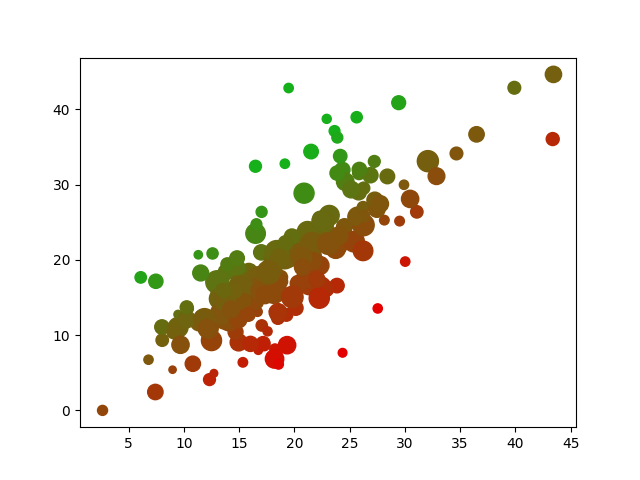

In [376]:
preds, results = get_best_player('Tracer', 'Eliminations', min_time=1.5)

In [373]:
print(wide_stats.loc[34492, "King's Row"]['Echo'])
outcomes[34492, "King's Row"]

stat_name        All Damage Done  Assists  Barrier Damage Done  \
team_name                                                        
Atlanta Reign        46708.14678     17.0          19044.73937   
Toronto Defiant              NaN      NaN                  NaN   

stat_name        Critical Hit Kills  Critical Hits  Damage - Duplicate  \
team_name                                                                
Atlanta Reign                   2.0           87.0         3981.803059   
Toronto Defiant                 NaN            NaN                 NaN   

stat_name        Damage - Focusing Beam  \
team_name                                 
Atlanta Reign               2616.079734   
Toronto Defiant                     NaN   

stat_name        Damage - Focusing Beam - Bonus Damage Only  \
team_name                                                     
Atlanta Reign                                   1768.292795   
Toronto Defiant                                         NaN   

stat_name   

team_name
Atlanta Reign       True
Toronto Defiant    False
dtype: bool

In [ ]:
%matplotlib notebook

<IPython.core.display.Javascript object>


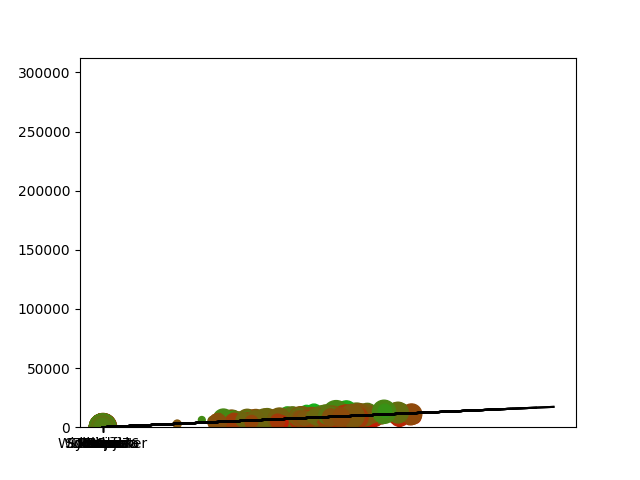

In [316]:
weighted_avg = lambda x: (x['value'] * x['weight']).sum() / x['weight'].sum()

avg = preds.groupby('player_name').apply(weighted_avg)

dif_df = results.copy()
dif_df['value'] -= preds['value']
diff = dif_df.groupby('player_name').apply(weighted_avg)

weights = dif_df['weight'].groupby('player_name').sum()

fig, ax = plt.subplots()
sc = plt.scatter(avg, diff, s=weights / 40)
cid = create_annotate(fig, ax, [sc], labels=[avg.index])
plt.show()